# Implementation of The Caption2Image

In [1]:
import h5py
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
encoded_train_X = torch.load("data/encoded_train_X.pt", map_location=device)
train_image_features = torch.load("data/train_image_features.pt", map_location=device)
train_Y_indices = np.load("data/train_Y.npy") - 1
encoded_vadidation_X = torch.load("data/encoded_validation_X.pt", map_location="cpu")[:1000].to(device)
validation_Y_indices = np.load("data/validation_Y.npy")[:1000] - 1
encoded_train_X.shape, train_image_features.shape, train_Y_indices.shape

(torch.Size([309375, 512]), torch.Size([82783, 512]), (309375,))

In [3]:
transformer_decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8, batch_first=True, activation="relu", device=device)
prior = torch.nn.TransformerDecoder(transformer_decoder_layer, num_layers=6).to(device)
MAX_EPOCH = 75
BATCH_SIZE = 2048
LR = 1e-4
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(prior.parameters(), lr=LR)
max_i = list(range(0, encoded_train_X.shape[0], BATCH_SIZE))[-1]
DIFF_SIZE= 10

In [ ]:
for epoch in range(MAX_EPOCH):
    prior.train()
    for i in range(0, encoded_train_X.shape[0], BATCH_SIZE):
        if i == max_i:
            break
        encoded_train_X_batch = encoded_train_X[i:i+BATCH_SIZE][:,None,:]
        train_image_features_batch = train_image_features[train_Y_indices[i:i+BATCH_SIZE]][:,None,:]
        optimizer.zero_grad()
        out1 = prior(encoded_train_X_batch, train_image_features_batch)
        loss: torch.Tensor = criterion(out1, train_image_features_batch)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{MAX_EPOCH} Batch {i//BATCH_SIZE}/{max_i//BATCH_SIZE} -- Loss: {loss.item():.4f}", end="\r")
    prior.eval()
    with torch.no_grad():
        out = prior(encoded_vadidation_X[:,None,:], train_image_features[validation_Y_indices][:,None,:])
        loss: torch.Tensor = criterion(out, train_image_features[validation_Y_indices][:,None,:])
        print(f"End of Epoch {epoch}/{MAX_EPOCH} -- Validation Loss: {loss.item():.6f}")



In [5]:
#torch.save(prior.state_dict(), "prior_backup2")

In [6]:
nz = 512
ngf = 64
nc = 3
ngpu = 1

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

decoder = Generator(ngpu)
decoder.load_state_dict(torch.load("decoder_model"))
docoder = decoder.to(device)
decoder.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [26]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from PIL import Image
import io
import requests
with h5py.File("data/eee443_project_dataset_train.h5", "r") as f:
    print("Keys: %s" % f.keys())
    train_cap = np.array(f["train_cap"])
    train_imid = np.array(f["train_imid"])
    #train_ims = np.array(f["train_ims"])
    train_url = np.array(f["train_url"])
    word_code = np.array(f["word_code"])
words = np.array(word_code.dtype.names)
word_indices = np.array(list(word_code[0]), dtype=np.int32)
with h5py.File("data/eee443_project_dataset_test.h5", "r") as f:
    print("Keys: %s" % f.keys())
    test_cap = np.array(f["test_caps"])
    test_imid = np.array(f["test_imid"])
    #test_ims = np.array(f["test_ims"])
    test_url = np.array(f["test_url"])
transformer_decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8, batch_first=True, activation="relu", device=device)
prior = torch.nn.TransformerDecoder(transformer_decoder_layer, num_layers=6).to(device)
print(prior.load_state_dict(torch.load("prior_backup2")))
train_cap.shape, train_imid.shape, train_url.shape, test_cap.shape, test_imid.shape, test_url.shape, words.shape

Keys: <KeysViewHDF5 ['train_cap', 'train_imid', 'train_ims', 'train_url', 'word_code']>
Keys: <KeysViewHDF5 ['test_caps', 'test_imid', 'test_ims', 'test_url']>
<All keys matched successfully>


((400135, 17), (400135,), (82783,), (195954, 17), (195954,), (40504,), (1004,))

In [27]:
train_visual_map = {"1": "53315.jpg", "2": "21549.jpg", "3": "53315.jpg", "4": "21549.jpg", "5": "43078.jpg"}
test_visual_map = {"1": "30770.jpg", "2": "26743.jpg", "3": "27731.jpg", "4": "8263.jpg", "5": "17549.jpg"}
test_imid[:8], train_imid[:5]

(array([30770, 26743, 27731,  8263, 17549, 17549, 27731, 27731],
       dtype=int32),
 array([53315, 21549, 53315, 21549, 43078], dtype=int32))

In [28]:
encoded_test_caption1 = torch.load("data/encoded_test_captions.pt")[:5].to("cpu")
test_image_indices = np.load("data/test_Y.npy")[:5]
test_image_features = torch.load("data/test_image_features.pt")[test_image_indices].to("cpu")
test_imid[1], test_url[26743], encoded_test_caption1[None,None].shape
#test_out = prior(encoded_test_caption1[None,None], torch.zeros_like(test_image_features[None,None], device=device) )
test_out = torch.zeros((5,512))
prior.eval()
with torch.no_grad():
    for i in range(5):
        test_out[i,:] = prior(encoded_test_caption1[i,None,:].to(device), test_image_features[i,None,:].to(device)).to("cpu")
test_out = torch.reshape(test_out, (5,512,1,1))

In [29]:
test_image_features[:,:, None, None].shape, test_out.shape
test_visual_map[str(i)], i

('8263.jpg', 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

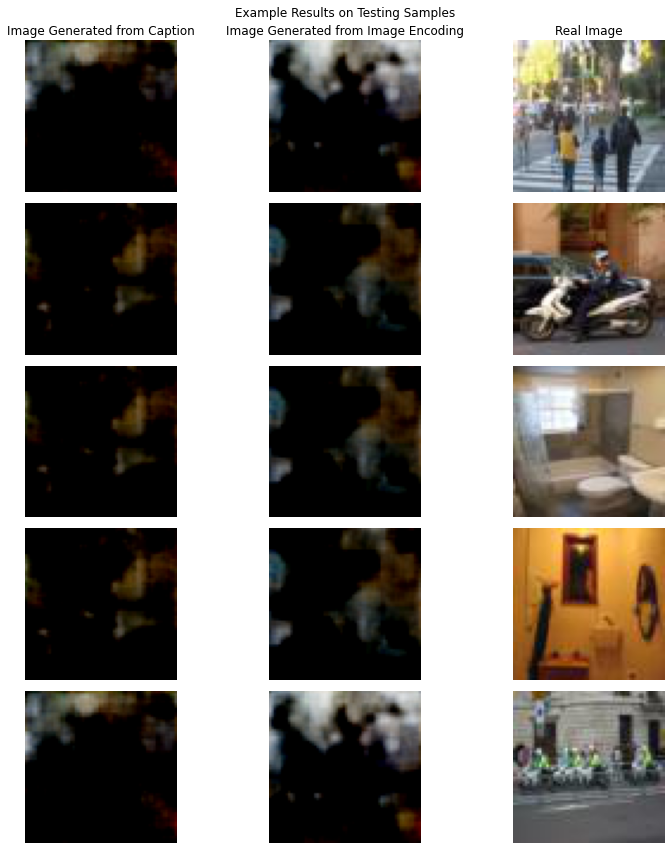

In [30]:
with torch.no_grad():
    images_from_text = decoder(test_out.to(device))
    images_from_encodings = decoder(test_image_features[:,:, None, None].to(device))
N = images_from_text.shape[0]
plt.figure(figsize=(12,12))
plt.suptitle("Example Results on Testing Samples")
for i in range(N):
    plt.subplot(N,3,i*3+1)
    plt.imshow(images_from_text[i].permute(1,2,0).cpu().detach().numpy())
    if i == 0:
        plt.title("Image Generated from Caption")
    plt.axis("off")
    plt.subplot(N,3,i*3+2)
    plt.imshow(images_from_encodings[i].permute(1,2,0).cpu().detach().numpy())
    if i == 0:
        plt.title("Image Generated from Image Encoding")
    plt.axis("off")
    plt.subplot(N,3,i*3+3)
    real_img = Image.open("display_images/test/"+test_visual_map[str(i+1)])
    plt.imshow(real_img)
    if i == 0:
        plt.title("Real Image")
    plt.axis("off")
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

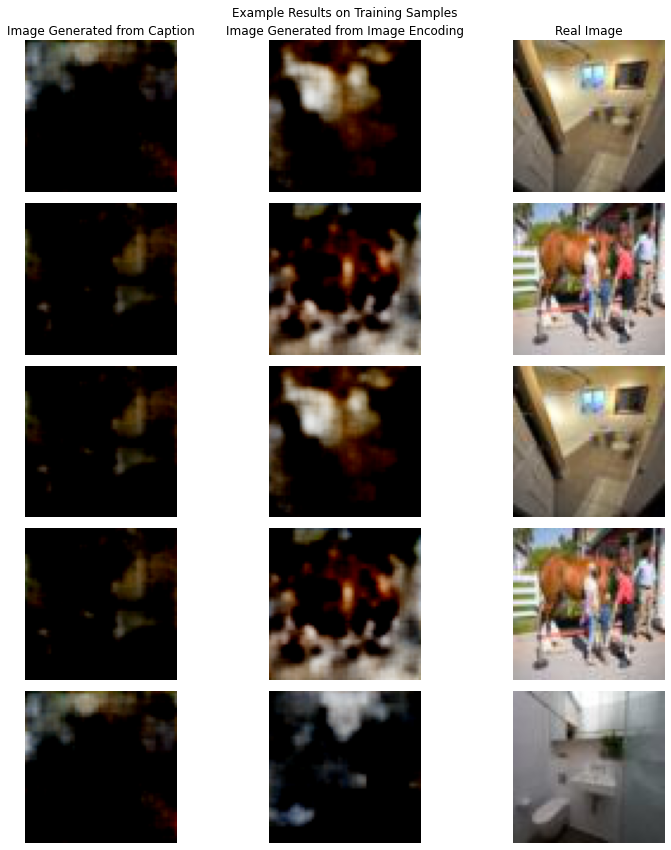

In [31]:
with torch.no_grad():
    train_image_features1 = train_image_features[train_imid[:5]]
    train_caption_encodings = encoded_train_X[:5]
    train_out = torch.zeros((5,512))
    for i in range(5):
        train_out[i,:] = prior(train_caption_encodings[i,None,:].to(device), train_image_features1[i,None,:].to(device))
    images_from_text_train = decoder(test_out.to(device))
    images_from_encodings_train = decoder(train_image_features1[:,:, None,None])
N = images_from_text_train.shape[0]
plt.figure(figsize=(12,12))
plt.suptitle("Example Results on Training Samples")
for i in range(N):
    plt.subplot(N,3,i*3+1)
    plt.imshow(images_from_text_train[i].permute(1,2,0).cpu().detach().numpy())
    if i == 0:
        plt.title("Image Generated from Caption")
    plt.axis("off")
    plt.subplot(N,3,i*3+2)
    plt.imshow(images_from_encodings_train[i].permute(1,2,0).cpu().detach().numpy())
    if i == 0:
        plt.title("Image Generated from Image Encoding")
    plt.axis("off")
    plt.subplot(N,3,i*3+3)
    real_img = Image.open("display_images/train/"+train_visual_map[str(i+1)])
    plt.imshow(real_img)
    if i == 0:
        plt.title("Real Image")
    plt.axis("off")
    plt.tight_layout()